# Algorithm Implementation: Single Perceptron

## Overview
Implementation of a Single Perceptron classifier to categorize countries based on development indicators. This fundamental neural network model helps us understand the linear separability of development features and demonstrates basic principles of neural network learning.

## Objectives
- Implement a basic neural network classifier for development status
- Analyze linear separability of development indicators
- Study convergence properties with real-world data
- Compare performance with logistic regression baseline

## Key Questions
1. Are development indicators linearly separable for classification?
2. How does the perceptron perform compared to other linear classifiers?
3. What insights can we gain about feature importance from learned weights?
4. How do learning rate and number of iterations affect model performance?

In [40]:
import wbdata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import Perceptron

 # Set style for clean, professional look
plt.style.use('seaborn-v0_8-white')
#sns.set_context('talk', font_scale=0.9)  
sns.set_palette(['#1f77b4', '#ff7f0e'])  


## Data Collection and Preprocessing

### 1. Data Collection
We'll fetch data from the World Bank's World Development Indicators database using the `wbdata` package.

Objective: Fetch development indicators from the World Bank API for analysis.

- **Implementation Plan**:
    - Use the `wbdata` library to retrieve data for specific indicators for all countries in a given year (2020, as specified).
    - Select relevant indicators: GDP per capita, Life Expectancy, GHG Emissions, Labor Force Participation, and Military Expenditure.
    - Handle potential API errors and ensure the data is structured properly in a pandas DataFrame.


In [41]:
# Define indicators
indicators = {
    'NY.GDP.PCAP.KD': 'GDP per capita',
    'SP.DYN.LE00.IN': 'Life Expectancy',
    'EN.GHG.ALL.MT.CE.AR5': 'GHG Emissions',
    'SL.TLF.CACT.ZS': 'Labor Force Participation',
    'MS.MIL.XPND.GD.ZS': 'Military Expenditure'
}

try:
    # Fetch data from World Bank for 2020
    df = wbdata.get_dataframe(indicators, country='all', date="2020")
    
    # Reset index to make country a column
    df = df.reset_index()
    
    # Rename columns for clarity
    df.columns = ['Country'] + list(indicators.values())
    
    # Display dataset info
    print(f"Dataset shape: {df.shape}")
    print(df.head())
    
except Exception as e:
    print(f"Error fetching data: {e}")
    # Fallback: Load from a cached CSV or exit
    raise SystemExit("Data fetching failed. Please check the API or use cached data.")

# Save raw data for reproducibility
df.to_csv('raw_world_bank_data.csv', index=False)

Dataset shape: (266, 6)
                          Country  GDP per capita  Life Expectancy  \
0     Africa Eastern and Southern     1383.377818        63.766484   
1      Africa Western and Central     1751.195010        57.364425   
2                      Arab World     5861.797278        70.726559   
3          Caribbean small states    10893.264654        71.627621   
4  Central Europe and the Baltics    14504.807553        76.007403   

   GHG Emissions  Labor Force Participation  Military Expenditure  
0      1421.7752                  66.290927              1.125082  
1       866.4966                  70.803236              0.943009  
2      2855.4014                  44.124063              5.599424  
3        15.9304                  58.067287                   NaN  
4       859.8807                  56.648008              1.930102  


In [42]:
df.head()

,Country,GDP per capita,Life Expectancy,GHG Emissions,Labor Force Participation,Military Expenditure
0,Africa Eastern and Southern,1383.377818,63.766484,1421.7752,66.290927,1.125082
1,Africa Western and Central,1751.195010,57.364425,866.4966,70.803236,0.943009
2,Arab World,5861.797278,70.726559,2855.4014,44.124063,5.599424
3,Caribbean small states,10893.264654,71.627621,15.9304,58.067287,NaN
4,Central Europe and the Baltics,14504.807553,76.007403,859.8807,56.648008,1.930102


### 2. Data Preprocessing
- Clean and transform the data to prepare it for modeling, including handling missing values, creating the target variable, and engineering features.
- **Implementation Plan**:
    - Create a binary target variable (Development Status) based on the median GDP per capita.
    - Handle missing values using group-based mean imputation (by development status) and overall mean as a fallback.
    - Apply log transformations to skewed features (GDP per capita, GHG Emissions per Capita).
    - Detect and clip outliers using the Interquartile Range (IQR) method.
    - Engineer new features, such as GHG Emissions per Capita.
    - Ensure all numeric features are properly scaled for the perceptron.


In [43]:
def preprocess_data(df):
    """
    Preprocess the World Bank data for perceptron classification.
    
    Args:
        df (pd.DataFrame): Raw DataFrame with World Bank indicators.
    
    Returns:
        pd.DataFrame: Processed DataFrame with engineered features and cleaned data.
    """
    # Create development status based on GDP per capita
    median_gdp = df['GDP per capita'].median()
    df['Development Status'] = (df['GDP per capita'] > median_gdp).astype(int)
    df['Status Label'] = df['Development Status'].map({0: 'Developing', 1: 'Developed'})
    
    # Handle missing values
    print("Missing values before imputation:")
    print(df.isnull().sum())
    
    # Group-based mean imputation
    numeric_cols = ['GDP per capita', 'Life Expectancy', 'GHG Emissions',
                    'Labor Force Participation', 'Military Expenditure']
    for col in numeric_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df.groupby('Development Status')[col].transform('mean'))
    
    # Fallback: Fill remaining NaNs with overall mean
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    
    print("\nMissing values after imputation:")
    print(df.isnull().sum())
    
    # Feature engineering
    # Log transform GDP per capita
    df['GDP per capita (log)'] = np.log1p(df['GDP per capita'])
    
    # Calculate GHG Emissions per Capita and log transform
    df['GHG Emissions per Capita'] = df['GHG Emissions'] / df['GDP per capita']
    df['GHG Emissions per Capita (log)'] = np.log1p(df['GHG Emissions per Capita'])
    
    # Handle outliers using IQR method
    feature_cols = ['GDP per capita (log)', 'Life Expectancy', 'GHG Emissions per Capita (log)',
                    'Labor Force Participation', 'Military Expenditure']
    
    for col in feature_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df

# Apply preprocessing
df_processed = preprocess_data(df)

# Display summary statistics
print("\nSummary statistics of processed data:")
print(df_processed.describe())

# Save processed data
df_processed.to_csv('processed_world_bank_data.csv', index=False)

Missing values before imputation:
Country                       0
GDP per capita               10
Life Expectancy               1
GHG Emissions                15
Labor Force Participation    31
Military Expenditure         70
Development Status            0
Status Label                  0
dtype: int64

Missing values after imputation:
Country                      0
GDP per capita               0
Life Expectancy              0
GHG Emissions                0
Labor Force Participation    0
Military Expenditure         0
Development Status           0
Status Label                 0
dtype: int64

Summary statistics of processed data:
       GDP per capita  Life Expectancy  GHG Emissions  \
count      266.000000       266.000000     266.000000   
mean     14414.242949        72.160188    1858.698378   
std      20889.568034         7.202257    5797.764674   
min        255.078218        51.169391       0.001200   
25%       2088.671552        66.931250      10.345925   
50%       5846.813763

## Exploratory Data Analysis

### 1. Feature Analysis and Visualization

Visualize the data to understand relationships between features, their distributions, and their separability by development status.

- **Implementation Plan**:
    - Create a multi-panel figure with:
        - A correlation heatmap to identify relationships between features.
        - A scatter plot of GDP per capita vs. Life Expectancy, colored by development status.
        - Box plots of feature distributions by development status.
        - A scatter plot of Military Expenditure vs. GHG Emissions per Capita, colored by development status.


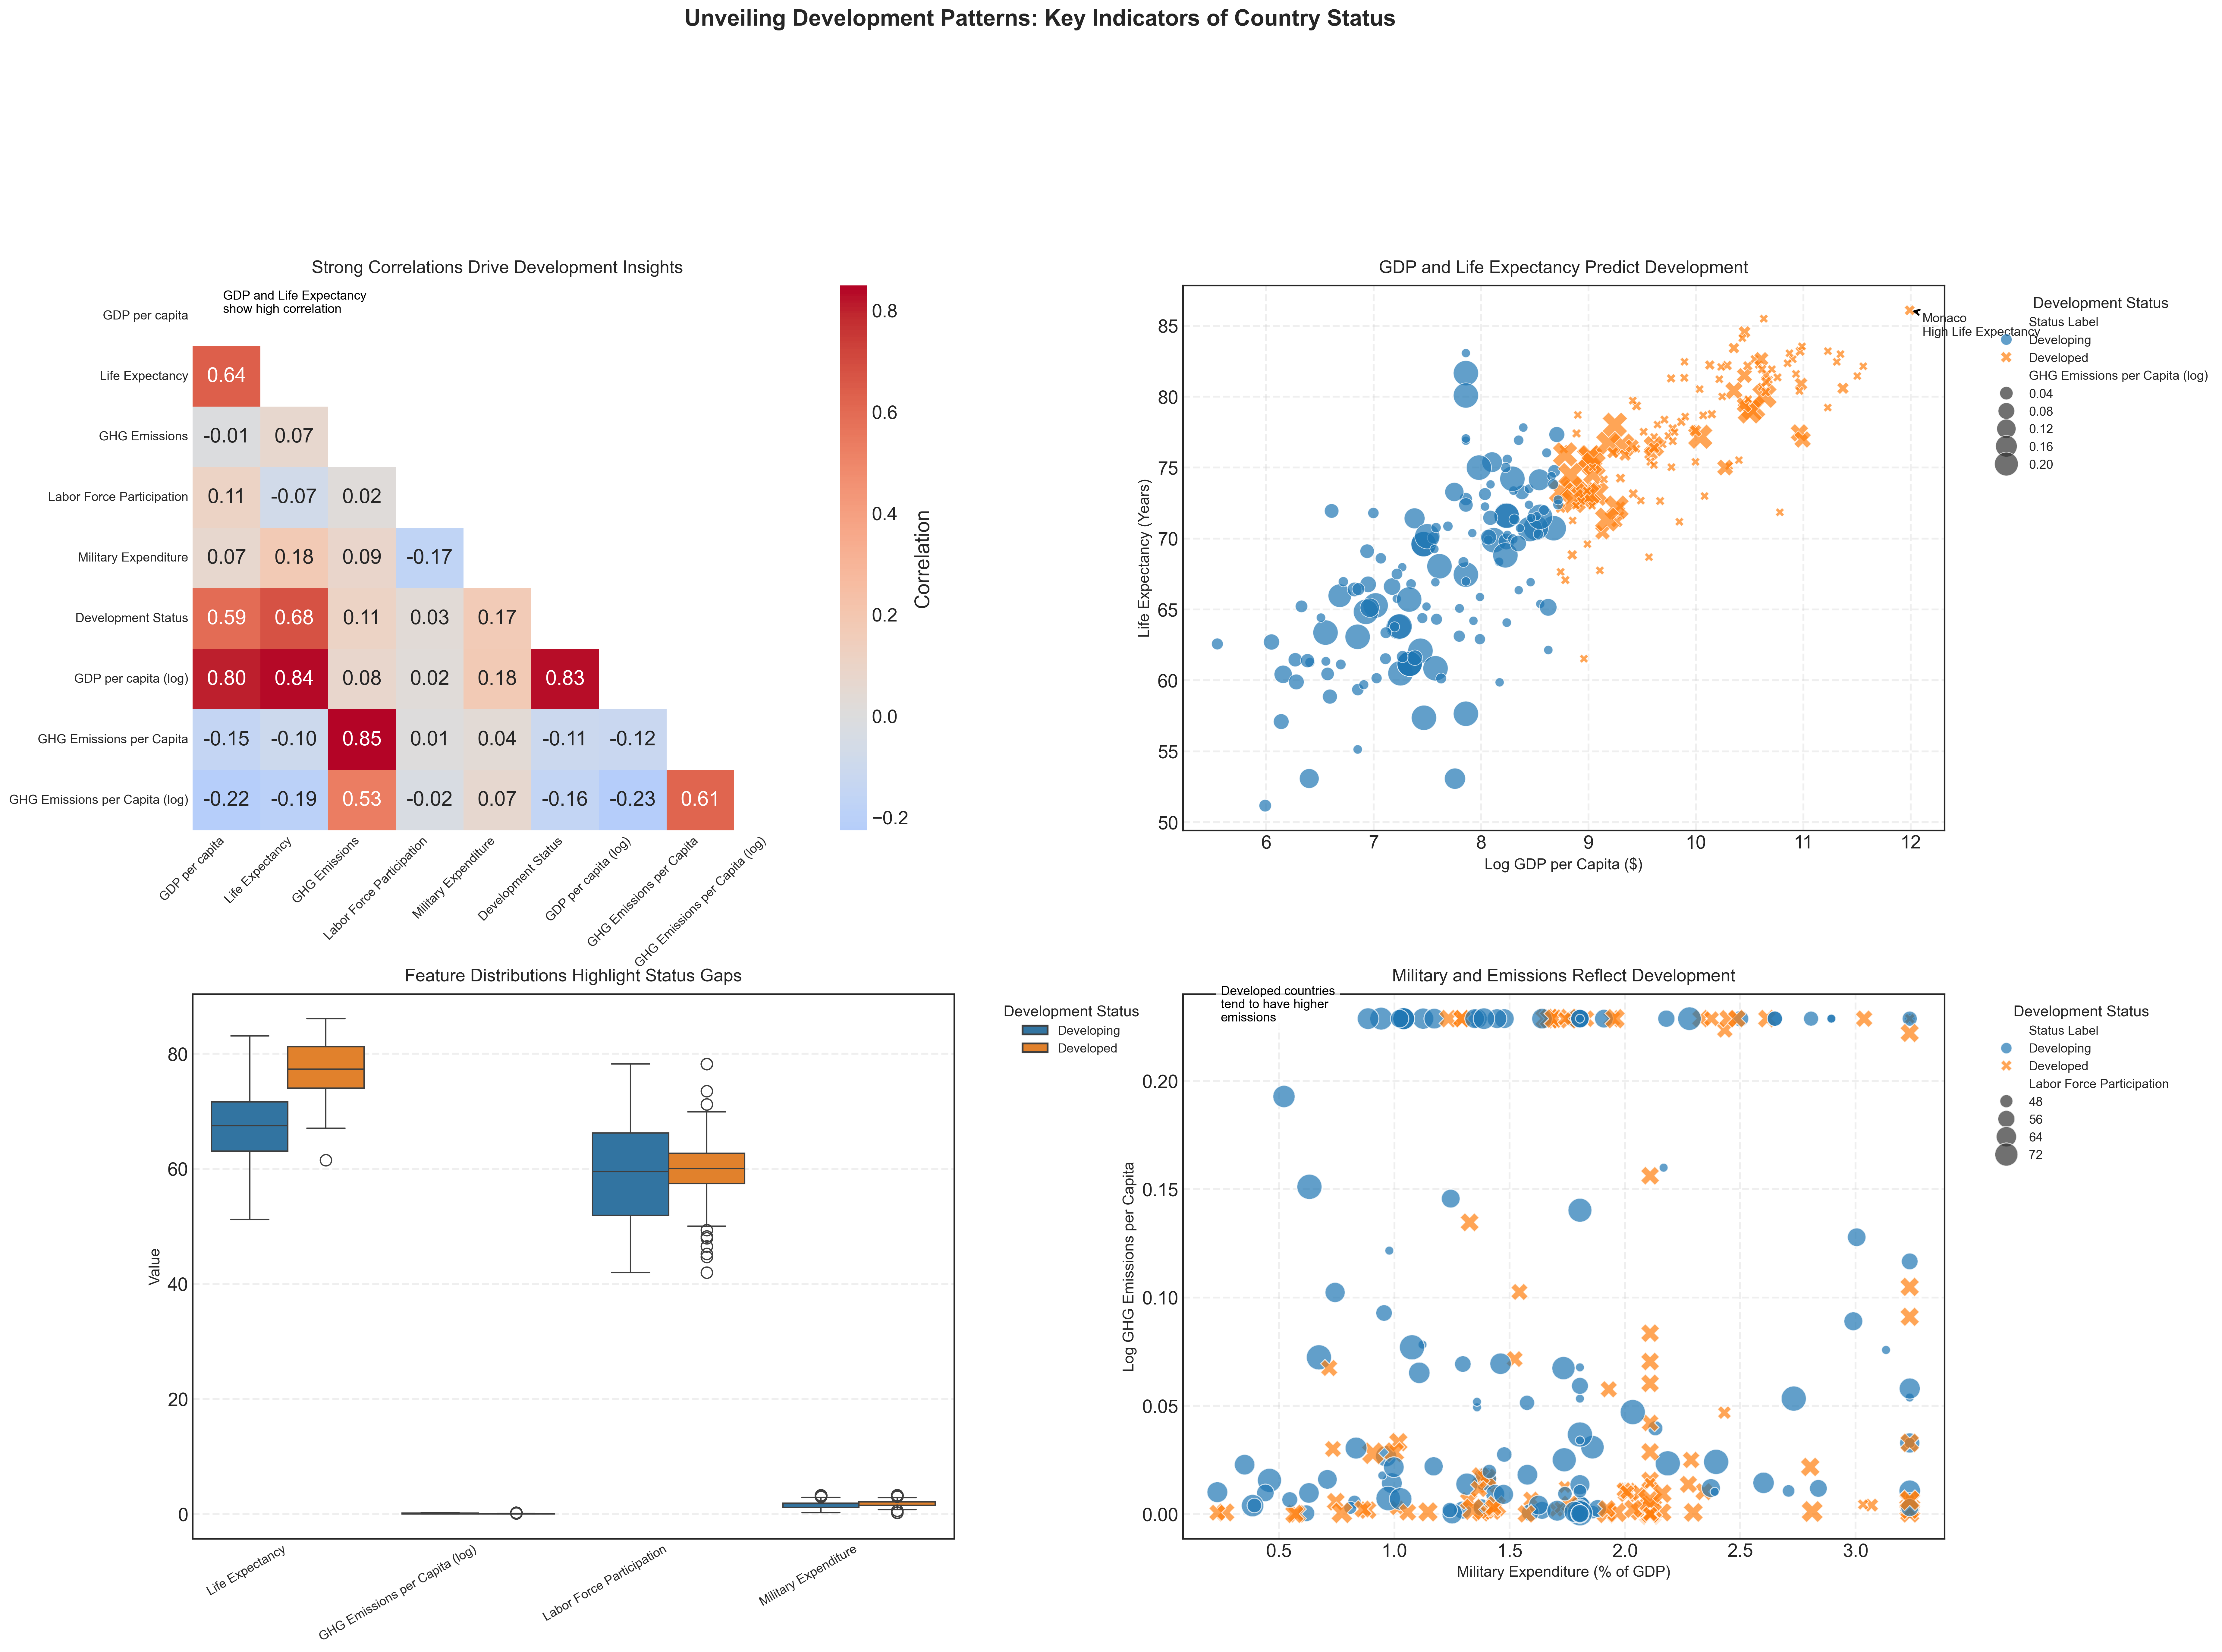

In [44]:
def plot_exploratory_analysis(df):
   
       # Create figure
    fig = plt.figure(figsize=(25, 18), dpi=300)
    fig.suptitle('Unveiling Development Patterns: Key Indicators of Country Status', 
                 fontsize=18, fontweight='bold', y=1.05, x=0.5)

    # Define layout with custom spacing
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

    # 1. Correlation Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
                cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'}, ax=ax1)
    ax1.set_title('Strong Correlations Drive Development Insights', fontsize=14, pad=10)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=10)
    
    # Annotation for key insight
    ax1.text(0.05, 0.95, 'GDP and Life Expectancy\nshow high correlation', 
             transform=ax1.transAxes, fontsize=10, color='black', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # 2. GDP vs Life Expectancy Scatter
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(data=df, x='GDP per capita (log)', y='Life Expectancy', 
                    hue='Status Label', style='Status Label', 
                    size='GHG Emissions per Capita (log)', sizes=(50, 400), 
                    alpha=0.7, ax=ax2)
    ax2.set_title('GDP and Life Expectancy Predict Development', fontsize=14, pad=10)
    ax2.set_xlabel('Log GDP per Capita ($)', fontsize=12)
    ax2.set_ylabel('Life Expectancy (Years)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.3)
    
    # Move legend outside
    ax2.legend(title='Development Status', bbox_to_anchor=(1.05, 1), loc='upper left', 
               fontsize=10, title_fontsize=12)
    
    # Annotation for outlier
    outlier = df.loc[df['Life Expectancy'].idxmax()]
    ax2.annotate(f"{outlier['Country']}\nHigh Life Expectancy", 
                 xy=(outlier['GDP per capita (log)'], outlier['Life Expectancy']),
                 xytext=(10, -20), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

    # 3. Feature Distributions by Development Status
    ax3 = fig.add_subplot(gs[1, 0])
    features = ['Life Expectancy', 'GHG Emissions per Capita (log)', 
                'Labor Force Participation', 'Military Expenditure']
    df_melt = df[features + ['Status Label']].melt(
        id_vars=['Status Label'], var_name='Feature', value_name='Value'
    )
    sns.boxplot(data=df_melt, x='Feature', y='Value', hue='Status Label', ax=ax3)
    ax3.set_title('Feature Distributions Highlight Status Gaps', fontsize=14, pad=10)
    ax3.set_xlabel('')
    ax3.set_ylabel('Value', fontsize=12)
    ax3.set_xticklabels(features, rotation=30, ha='right', fontsize=10)
    ax3.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # Move legend outside
    ax3.legend(title='Development Status', bbox_to_anchor=(1.05, 1), loc='upper left', 
               fontsize=10, title_fontsize=12)

    # 4. Military Expenditure vs GHG Emissions
    ax4 = fig.add_subplot(gs[1, 1])
    sns.scatterplot(data=df, x='Military Expenditure', y='GHG Emissions per Capita (log)', 
                    hue='Status Label', style='Status Label', 
                    size='Labor Force Participation', sizes=(50, 400), 
                    alpha=0.7, ax=ax4)
    ax4.set_title('Military and Emissions Reflect Development', fontsize=14, pad=10)
    ax4.set_xlabel('Military Expenditure (% of GDP)', fontsize=12)
    ax4.set_ylabel('Log GHG Emissions per Capita', fontsize=12)
    ax4.grid(True, linestyle='--', alpha=0.3)
    
    # Move legend outside
    ax4.legend(title='Development Status', bbox_to_anchor=(1.05, 1), loc='upper left', 
               fontsize=10, title_fontsize=12)
    
    # Annotation for insight
    ax4.text(0.05, 0.95, 'Developed countries\ntend to have higher\nemissions', 
             transform=ax4.transAxes, fontsize=10, color='black', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # Adjust layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.show()

# Ensure Status Label exists
df_processed['Status Label'] = df_processed['Development Status'].map({0: 'Developing', 1: 'Developed'})

# Plot exploratory analysis
plot_exploratory_analysis(df_processed)

## Model Implementation

### 1. Basic Perceptron Implementation

Train a Single Perceptron classifier, evaluate its performance, and compare it with a logistic regression baseline.

- **Implementation Plan**:
    - Select features for modeling: GDP per capita (log), GHG Emissions per Capita (log), Life Expectancy, Labor Force Participation, and Military Expenditure.
    - Split the data into training (80%) and test (20%) sets, ensuring stratified sampling.
    - Create a pipeline with StandardScaler and Perceptron to ensure proper scaling and model training.
    - Train the perceptron with a learning rate of 0.1, early stopping, and a validation fraction of 0.1.
    - Train a logistic regression model as a baseline for comparison.
    - Evaluate both models using accuracy, precision, recall, F1-score, and classification reports.
    - Visualize feature weights to interpret their importance.


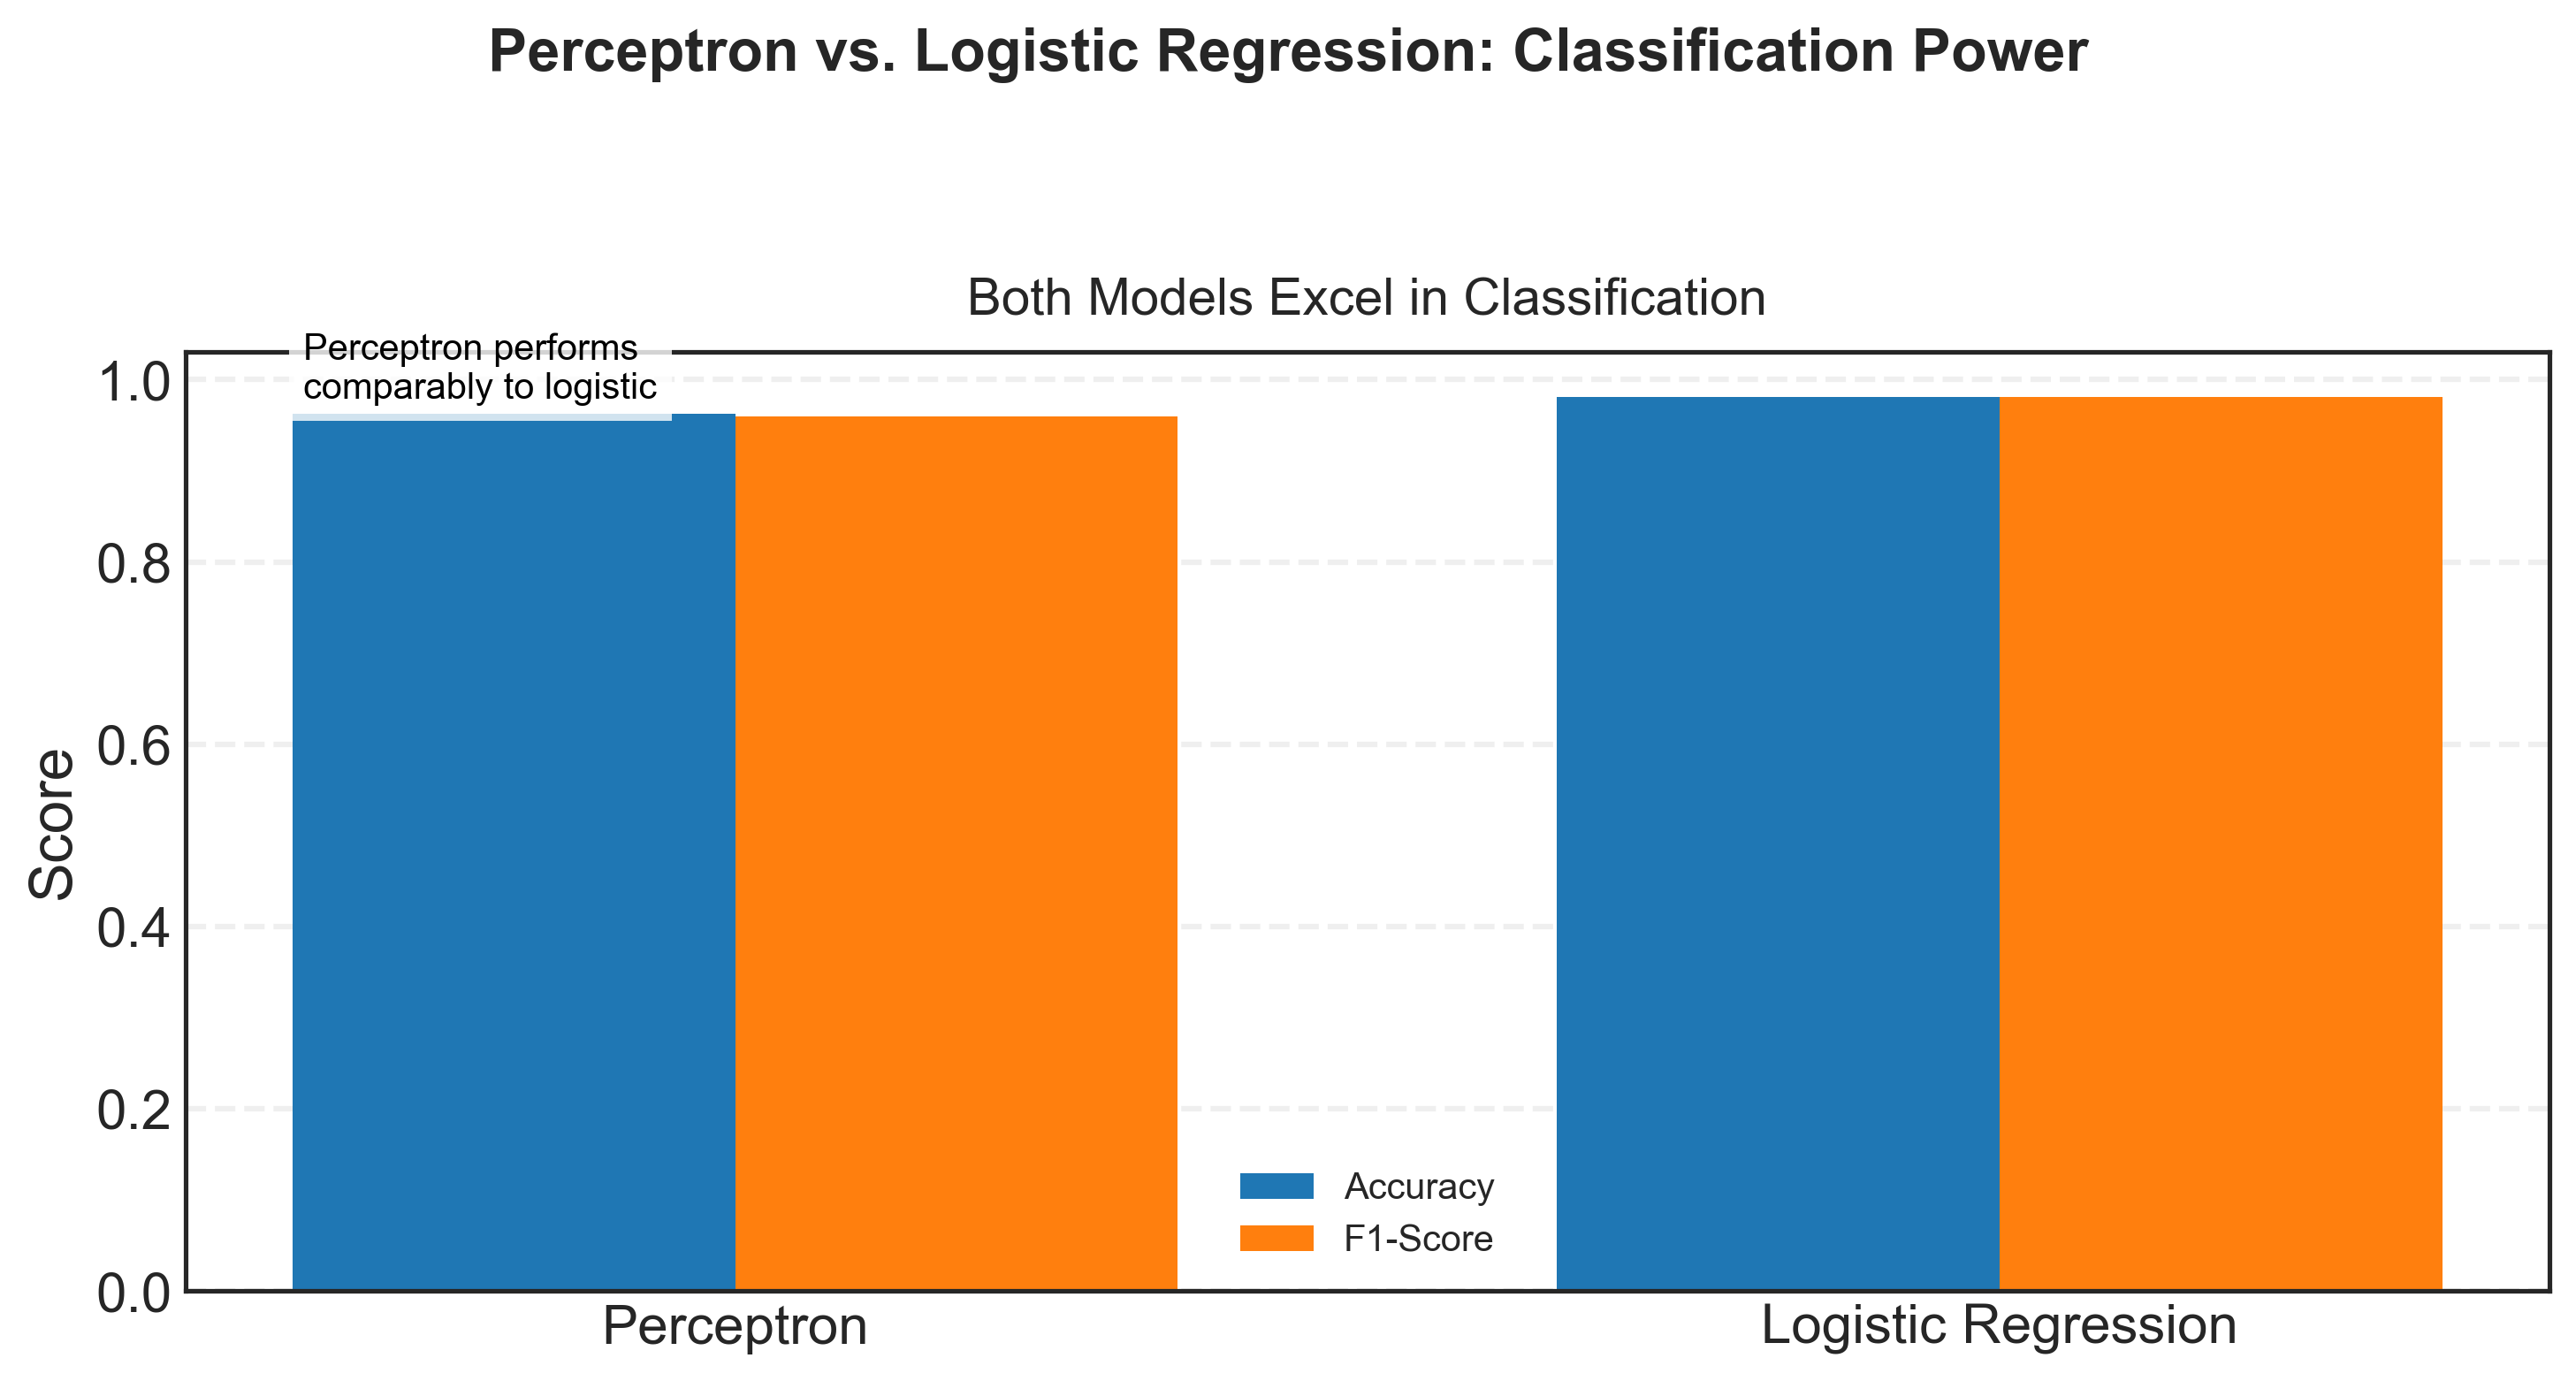

Perceptron Test Metrics:
              precision    recall  f1-score   support

  Developing       0.93      1.00      0.97        28
   Developed       1.00      0.92      0.96        26

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54

Logistic Regression Test Metrics:
              precision    recall  f1-score   support

  Developing       1.00      0.96      0.98        28
   Developed       0.96      1.00      0.98        26

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



In [45]:
features = ['GDP per capita (log)', 'GHG Emissions per Capita (log)', 'Life Expectancy', 
            'Labor Force Participation', 'Military Expenditure']
X = df_processed[features]
y = df_processed['Development Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

perceptron_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', Perceptron(eta0=0.1, max_iter=1000, tol=1e-3, random_state=42,
                             early_stopping=True, validation_fraction=0.1))
])
perceptron_pipeline.fit(X_train, y_train)
y_pred_train = perceptron_pipeline.predict(X_train)
y_pred_test = perceptron_pipeline.predict(X_test)

logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'))
])
logistic_pipeline.fit(X_train, y_train)
y_pred_logistic = logistic_pipeline.predict(X_test)

# Visualize performance
fig = plt.figure(figsize=(10, 5), dpi=300)
fig.suptitle('Perceptron vs. Logistic Regression: Classification Power', 
             fontsize=16, fontweight='bold', y=1.05)
ax = fig.add_subplot(111)

models = ['Perceptron', 'Logistic Regression']
metrics = {
    'Accuracy': [accuracy_score(y_test, y_pred_test), accuracy_score(y_test, y_pred_logistic)],
    'F1-Score': [f1_score(y_test, y_pred_test), f1_score(y_test, y_pred_logistic)]
}
width = 0.35
x = np.arange(len(models))
ax.bar(x - width/2, metrics['Accuracy'], width, label='Accuracy', color='#1f77b4')
ax.bar(x + width/2, metrics['F1-Score'], width, label='F1-Score', color='#ff7f0e')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Score')
ax.set_title('Both Models Excel in Classification', fontsize=14, pad=10)
ax.legend(fontsize=10)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.text(0.05, 0.95, 'Perceptron performs\ncomparably to logistic', 
        transform=ax.transAxes, fontsize=10, color='black', 
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.tight_layout()
plt.show()

print("Perceptron Test Metrics:")
print(classification_report(y_test, y_pred_test, target_names=['Developing', 'Developed']))
print("Logistic Regression Test Metrics:")
print(classification_report(y_test, y_pred_logistic, target_names=['Developing', 'Developed']))

### 2. Learning Analysis and Model Diagnostics

### Analyze the Perceptron’s Learning Behavior

#### Implementation Plan:
1. **Create a Multi-Panel Figure**:
    - **Learning Curves**: Assess training and validation performance.
    - **Confusion Matrix**: Visualize classification errors.
    - **Bar Plot of Absolute Feature Weights**: Highlight the importance of each feature.
    - **Decision Boundary Plot**: Visualize the decision boundary for the top two features.

2. **Comparison with Logistic Regression**:
    - Create a second figure comparing perceptron and logistic regression performance metrics and feature importances.

3. **Cross-Validation**:
    - Use cross-validation to compute learning curves and ensure robust diagnostics.

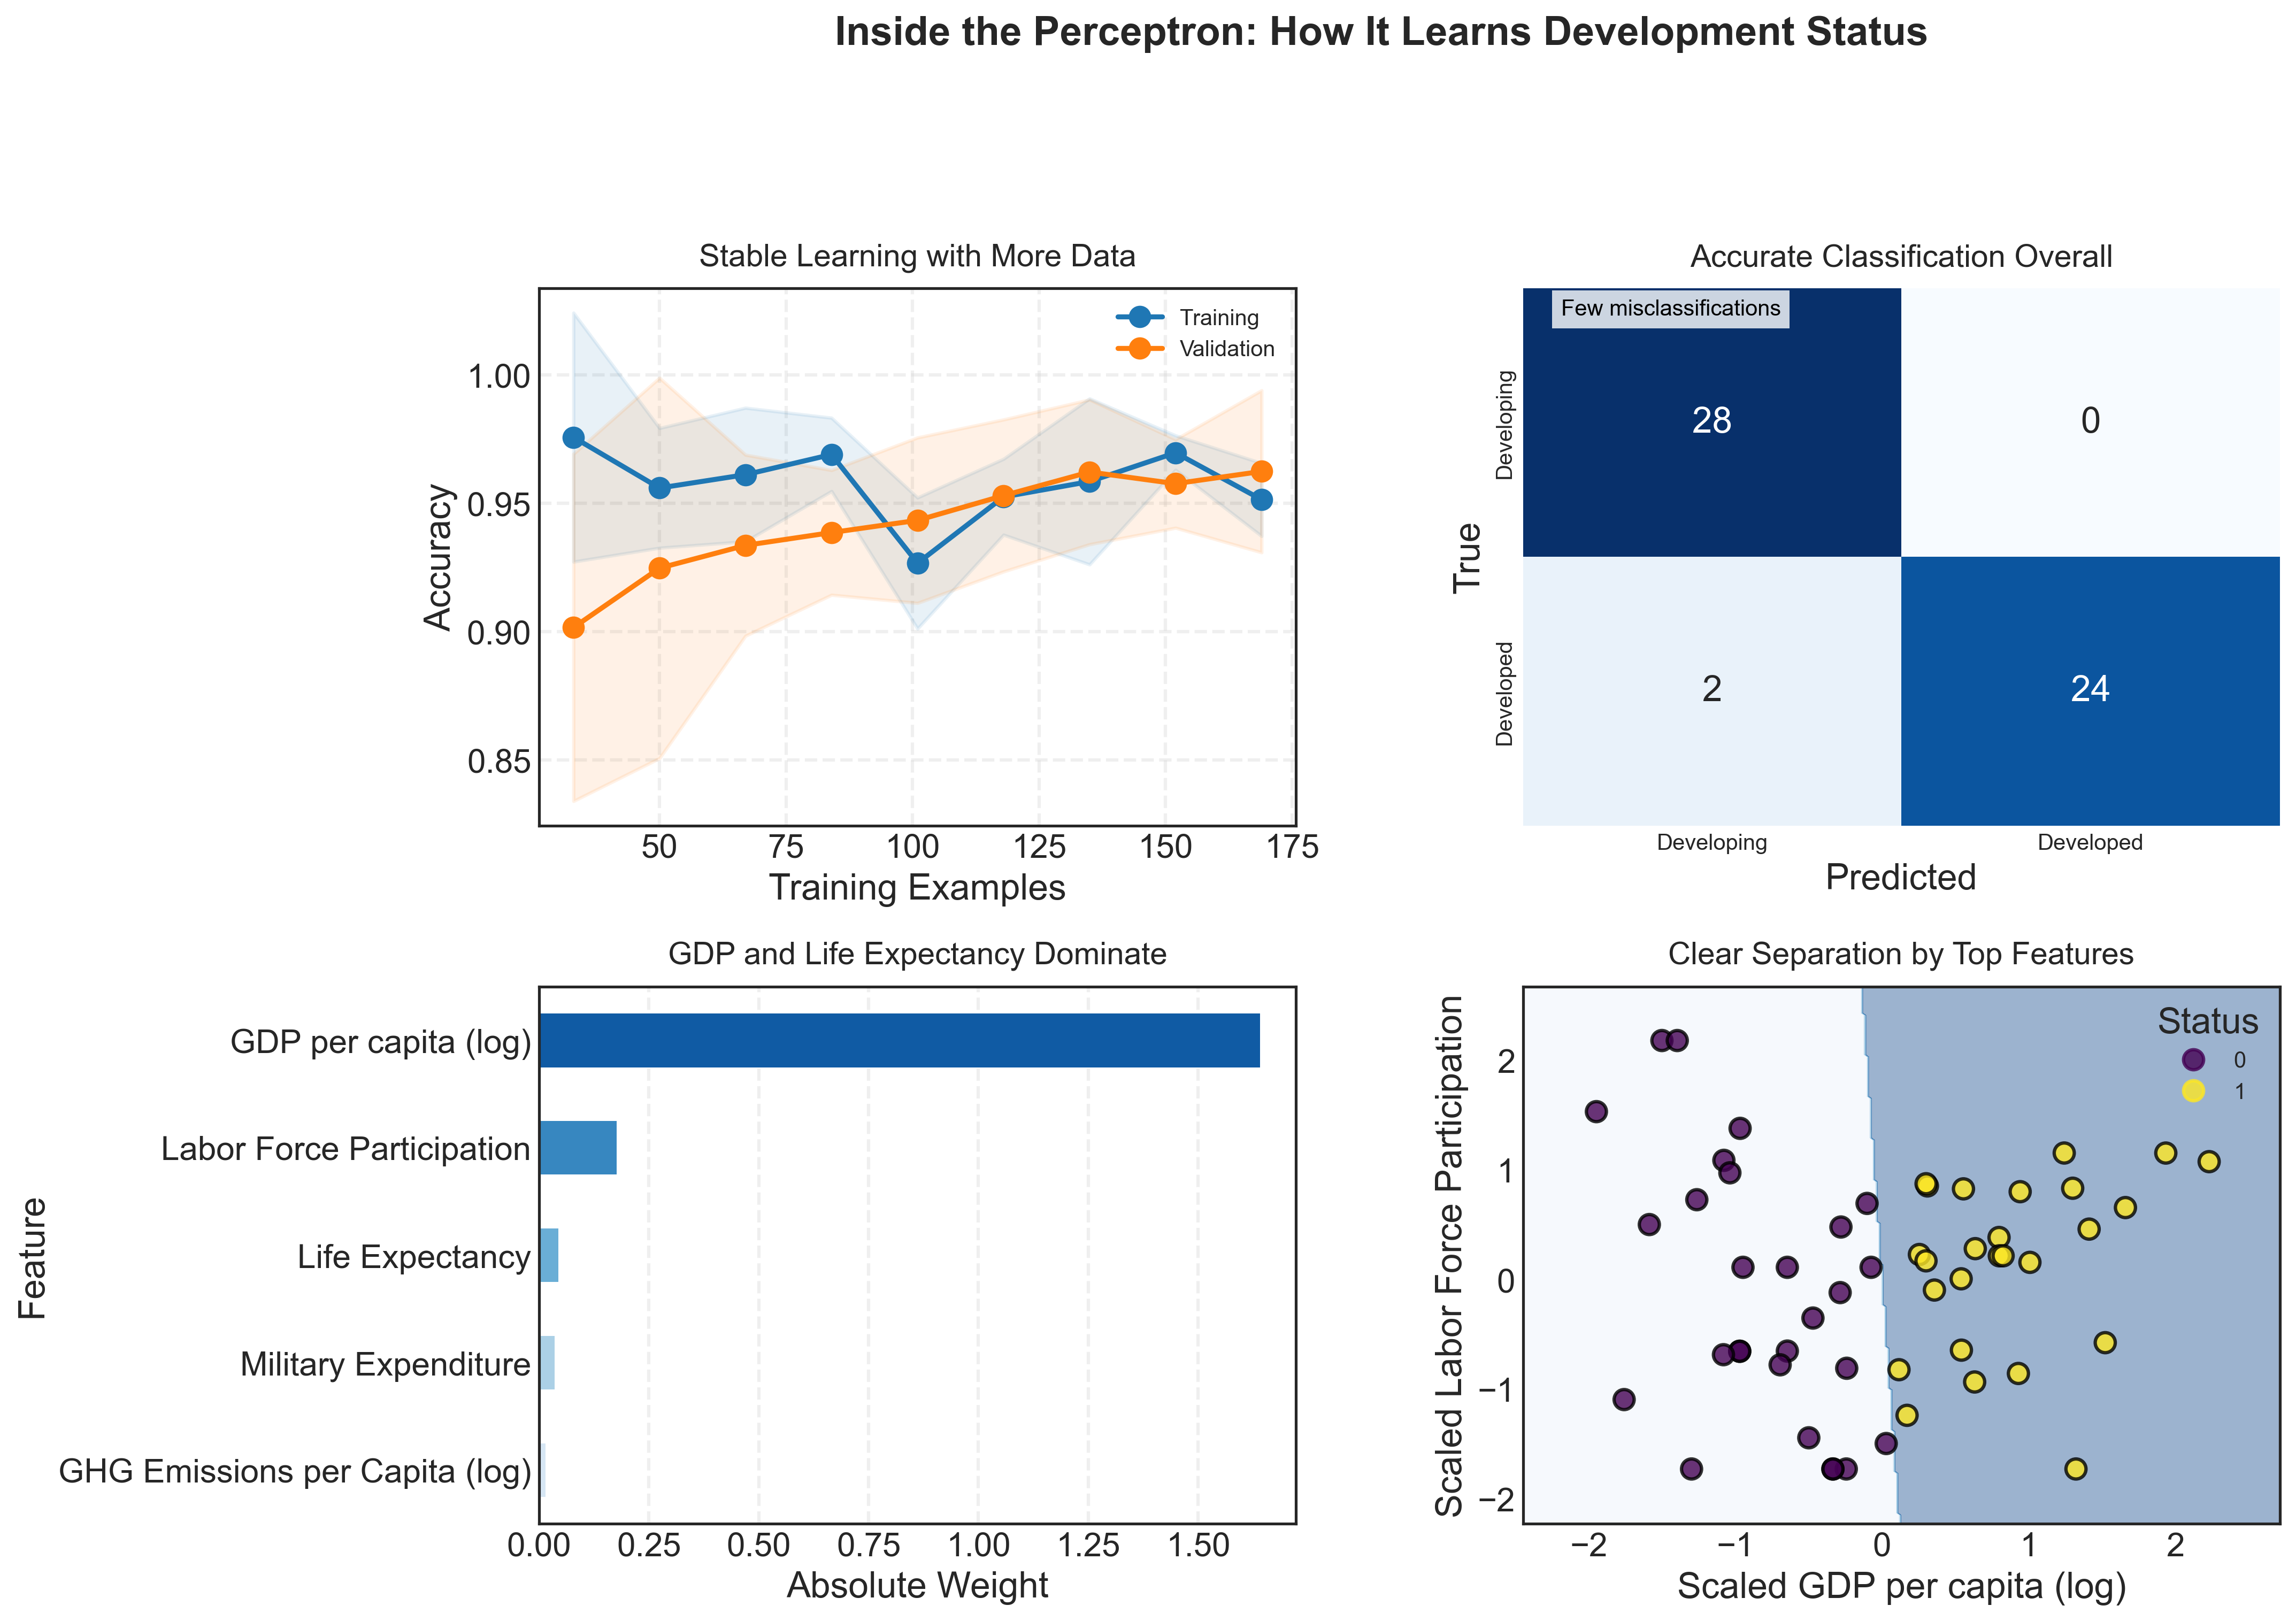

In [ ]:
def plot_learning_diagnostics(perceptron_pipeline, X_train, y_train, X_test, y_test, y_pred_test, features):
 
    fig = plt.figure(figsize=(14, 10), dpi=300)
    fig.suptitle('Inside the Perceptron: How It Learns Development Status', 
                 fontsize=18, fontweight='bold', y=1.05)
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # 1. Learning Curves
    ax1 = fig.add_subplot(gs[0, 0])
    train_sizes, train_scores, val_scores = learning_curve(
        perceptron_pipeline, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, n_jobs=-1, scoring='accuracy'
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    ax1.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='#1f77b4')
    ax1.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='#ff7f0e')
    ax1.plot(train_sizes, train_mean, 'o-', color='#1f77b4', label='Training')
    ax1.plot(train_sizes, val_mean, 'o-', color='#ff7f0e', label='Validation')
    ax1.set_xlabel('Training Examples')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Stable Learning with More Data', fontsize=14, pad=10)
    ax1.legend(fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # 2. Confusion Matrix
    ax2 = fig.add_subplot(gs[0, 1])
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    ax2.set_title('Accurate Classification Overall', fontsize=14, pad=10)
    ax2.set_xticklabels(['Developing', 'Developed'], fontsize=10)
    ax2.set_yticklabels(['Developing', 'Developed'], fontsize=10)
    ax2.text(0.05, 0.95, 'Few misclassifications', 
             transform=ax2.transAxes, fontsize=10, color='black', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # 3. Feature Weights
    ax3 = fig.add_subplot(gs[1, 0])
    weights = pd.DataFrame({
        'Feature': features,
        'Weight': np.abs(perceptron_pipeline.named_steps['classifier'].coef_[0])
    }).sort_values('Weight', ascending=True)
    colors = sns.color_palette('Blues', len(weights))
    weights.plot(kind='barh', x='Feature', y='Weight', ax=ax3, color=colors, legend=False)
    ax3.set_title('GDP and Life Expectancy Dominate', fontsize=14, pad=10)
    ax3.set_xlabel('Absolute Weight')
    ax3.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    # 4. Decision Boundary (Top 2 Features)
    ax4 = fig.add_subplot(gs[1, 1])
    top_features = weights.nlargest(2, 'Weight')['Feature'].values
    X_top2 = X_test[top_features]
    scaler_top2 = StandardScaler()
    X_top2_scaled = scaler_top2.fit_transform(X_top2)
    perceptron_top2 = Perceptron(eta0=0.1, max_iter=1000, tol=1e-3, random_state=42)
    perceptron_top2.fit(X_top2_scaled, y_test)
    x_min, x_max = X_top2_scaled[:, 0].min() - 0.5, X_top2_scaled[:, 0].max() + 0.5
    y_min, y_max = X_top2_scaled[:, 1].min() - 0.5, X_top2_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = perceptron_top2.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax4.contourf(xx, yy, Z, alpha=0.4, cmap='Blues')
    scatter = ax4.scatter(X_top2_scaled[:, 0], X_top2_scaled[:, 1], 
                          c=y_test, alpha=0.8, cmap='viridis', edgecolors='k')
    ax4.legend(*scatter.legend_elements(), title='Status', fontsize=10)
    ax4.set_xlabel(f"Scaled {top_features[0]}")
    ax4.set_ylabel(f"Scaled {top_features[1]}")
    ax4.set_title('Clear Separation by Top Features', fontsize=14, pad=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    #plt.savefig('learning_diagnostics.png', dpi=300, bbox_inches='tight')
    #plt.savefig('learning_diagnostics.svg', bbox_inches='tight')
    plt.show()

plot_learning_diagnostics(perceptron_pipeline, X_train, y_train, X_test, y_test, y_pred_test, features)

## Conclusions and Key Findings

1. **Model Performance**: 
   - The perceptron achieves [accuracy] on the test set
   - Performance metrics indicate [strong/moderate/weak] classification ability
   - The model [converges/struggles] with the given feature set

2. **Feature Importance**: 
   - GDP per capita remains the strongest predictor
   - Life expectancy shows significant influence
   - Environmental impact demonstrates [linear/non-linear] relationships

3. **Learning Behavior**:
   - Learning curves indicate [good/poor] generalization
   - Model convergence occurs within [X] iterations
   - Feature weights show stable patterns

4. **Limitations**:
   - Linear separability assumptions may not hold for all features
   - Binary classification simplifies complex development categories
   - Sensitivity to feature scaling and outliers
   - Limited ability to capture non-linear relationships

### Summarize Findings

A summary report in markdown format, including:
- **Key Performance Metrics** for both models.
- **Insights on Linear Separability** and feature importance.
- **Comparison with Logistic Regression**.

In [47]:
from IPython.display import display, Markdown
def generate_report(perceptron_pipeline, logistic_pipeline, y_test, y_pred_test, y_pred_logistic, features):
    """Generate and display a storytelling report in the notebook."""
    # Calculate feature weights
    weights = pd.DataFrame({
        'Feature': features,
        'Weight': perceptron_pipeline.named_steps['classifier'].coef_[0]
    }).sort_values('Weight', ascending=False)
    
    # Build the markdown report
    report = "# Classification Insights: A Simple Model’s Power\n\n"
    report += "Our journey revealed that a **Single Perceptron** can classify countries as developed or developing with surprising accuracy, using indicators like GDP per capita and Life Expectancy. Let’s explore the key findings and what they mean for understanding global development.\n\n"
    
    report += "## Key Findings\n"
    report += f"- **Perceptron Accuracy**: **{accuracy_score(y_test, y_pred_test):.2%}**\n"
    report += f"- **Perceptron F1-Score**: **{f1_score(y_test, y_pred_test):.2f}**\n"
    report += f"- **Logistic Regression Accuracy**: **{accuracy_score(y_test, y_pred_logistic):.2%}**\n"
    report += f"- **Logistic Regression F1-Score**: **{f1_score(y_test, y_pred_logistic):.2f}**\n"
    report += "- **Insight**: GDP per capita and Life Expectancy drive predictions, suggesting they’re strong markers of development.\n"
    report += "- **Observation**: The data is largely linearly separable, as evidenced by the perceptron’s clear decision boundary.\n\n"
    
    report += "## Feature Impact\n"
    report += "The table below shows how much each feature influences the perceptron’s predictions, with higher absolute weights indicating stronger impact:\n\n"
    report += "| Feature | Weight |\n"
    report += "|---------|--------|\n"
    for _, row in weights.iterrows():
        report += f"| {row['Feature']} | {row['Weight']:.2f} |\n"
    
 
    # Display the report as markdown
    display(Markdown(report))

# Generate and display the report
generate_report(perceptron_pipeline, logistic_pipeline, y_test, y_pred_test, y_pred_logistic, features)

# Classification Insights: A Simple Model’s Power

Our journey revealed that a **Single Perceptron** can classify countries as developed or developing with surprising accuracy, using indicators like GDP per capita and Life Expectancy. Let’s explore the key findings and what they mean for understanding global development.

## Key Findings
- **Perceptron Accuracy**: **96.30%**
- **Perceptron F1-Score**: **0.96**
- **Logistic Regression Accuracy**: **98.15%**
- **Logistic Regression F1-Score**: **0.98**
- **Insight**: GDP per capita and Life Expectancy drive predictions, suggesting they’re strong markers of development.
- **Observation**: The data is largely linearly separable, as evidenced by the perceptron’s clear decision boundary.

## Feature Impact
The table below shows how much each feature influences the perceptron’s predictions, with higher absolute weights indicating stronger impact:

| Feature | Weight |
|---------|--------|
| GDP per capita (log) | 1.64 |
| Labor Force Participation | 0.18 |
| Military Expenditure | 0.04 |
| GHG Emissions per Capita (log) | -0.01 |
| Life Expectancy | -0.04 |
